### User Searches for SXSW Interactive Sessions

Useful data engineering articles:
- https://www.analyticsvidhya.com/blog/2016/10/spark-dataframe-and-operations/
- https://hadoopist.wordpress.com/2016/05/16/how-to-handle-nested-dataarray-of-structures-or-multiple-explodes-in-sparkscala-and-pyspark/
- https://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=explode

### Prerequisites
We're going to use PixieDust to help visualize our data. You can learn more about PixieDust at https://ibm-cds-labs.github.io/pixiedust/.
In the following cell we ensure we are running the lastest version of PixieDust. Be sure to restart your kernel if instructed to do so.

In [ ]:
!pip install --user --upgrade pixiedust

In [1]:
import pixiedust
pixiedust.enableJobMonitor()

Pixiedust database opened successfully


Succesfully enabled Spark Job Progress Monitor


In [2]:
from pyspark.sql.functions import explode, lower

### Configure database connectivity

In [3]:
# The code was removed by DSX for sharing.

▸,:,


### Load documents from the database
Load the documents into an Apache Spark DataFrame.

In [4]:
# no changes are required to this cell
# obtain Spark SQL Context
sparkSession = SparkSession.builder.getOrCreate()
# load data
conversation_df = sparkSession.read.format("com.cloudant.spark").\
                                      option("cloudant.host", host).\
                                      option("cloudant.username", username).\
                                      option("cloudant.password", password).\
                                      load(database)

▸,:,


Use connectorVersion=2.0.0, dbName=sxswlog, indexName=null, viewName=null,jsonstore.rdd.partitions=10, jsonstore.rdd.maxInPartition=-1,jsonstore.rdd.minInPartition=10, jsonstore.rdd.requestTimeout=900000,bulkSize=200, schemaSampleSize=-1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Document Structure

Each document in the database represents a single conversation made with the chatbot. Each conversation includes the userId, date, and the steps of the conversation. The steps are stored in an array called dialogs (referring to the dialogs in Watson Conversation that were traversed as part of the conversation). Here is a sample list of dialogs in a conversation:

<code>
"dialogs": [
  {
    "name": "get_music_topic",
    "message": "Music",
    "date": 1489343583979
  },
  {
     "name": "search_music_topic",
     "message": "Brass bands",
     "date": 1489343600650
  }
]
</code>

In the following cell we print the schema to confirm the structure of the documents.

In [5]:
conversation_df.printSchema()

▸,:,


root
 |-- _id: string (nullable = true)
 |-- _rev: string (nullable = true)
 |-- date: long (nullable = true)
 |-- dialogs: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- date: long (nullable = true)
 |    |    |-- message: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |-- userId: string (nullable = true)



### How many conversations where there?
Let's start by showing how many conversations the Chatbot had at SXSW: 

In [6]:
conversation_df.count()

▸,:,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2597

<IPython.core.display.Javascript object>

### How many users installed the chatbot?
At SXSW we were able to demonstrate the chatbot on a laptop and display, or give users the ability to run the chatbot from their own phones. They could interact with the chatbot via SMS, or a mobile-optimized version of the web app. When running from the laptop the userId would be nothing more than a UUID. When running from a user's phone we stored the userId as the user's phone number starting with a "+". We are most interested in what types of conversations were had by users who installed the chatbot. Here we filter down to only those conversations:

In [7]:
phone_conversation_df = conversation_df.filter('userId LIKE "+%"')
phone_conversation_df.select('userId').distinct().count()

▸,:,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

354

<IPython.core.display.Javascript object>

### How many conversations made by users from their phones?
This next gets any conversation that traversed more than 1 dialog. If the user simply said "hi" and then never conversed with the chatbot after that then we don't want to count it as a conversation.

In [8]:
phone_conversation_df = phone_conversation_df.filter('size(dialogs) > 1')
phone_conversation_df.count()

▸,:,


<IPython.core.display.Javascript object>

733

<IPython.core.display.Javascript object>

### Flatten the Cloudant JSON document structure
Each dialog contains a message field which contains the message sent by the user, and a name field which represents the action performed by the system based on the message sent by the user and the current dialog in the conversation as managed by Watson Conversation. For example, the name "search_topic" maps to the action of searching for Interactive sessions. The name "search_film" maps to the action of searching for film screenings. We want to do some analysis on specific actions and the messages associated with those actions, so in the next cell we convert each row (which has the dialog array) into multiple rows - one for each dialog. This will make it easier for us to filter and aggregate based on the message and name fields in the dialogs.

In [9]:
phone_dialog_df = phone_conversation_df.select(phone_conversation_df.userId,explode(phone_conversation_df.dialogs).alias("dialog"))
phone_dialog_df = phone_dialog_df.select("dialog.date", lower(phone_dialog_df.dialog.message).alias("message"), "dialog.name")
phone_dialog_df.printSchema()

▸,:,


root
 |-- date: long (nullable = true)
 |-- message: string (nullable = true)
 |-- name: string (nullable = true)



### Display Dialogs in PixieDust
Below we display each dialog in a PixieDust table. You can see the date, message (the message the user sent to the chatbot), and name (the name of the action performed).

In [10]:
display(phone_dialog_df)

date,message,name
1489435246790,where is ibm stand?,search_food
1489435944456,andre,search_free_form
1489252675003,search interactive,get_topic
1489252687938,ar or vr,search_topic
1489527063634,hi,start_search
1489527084756,lindsey,get_name
1489184307555,music,get_music_topic
1489184313521,tpain,search_music_topic
1489525833157,hi,start_search
1489525862862,hb,get_name


### How many searches for SXSW Interactive sessions?
As mentioned early "search_topic" maps to the action of search for SXSW Interactive sessions. Here we get only those actions:

In [11]:
interactive_dialog_df = phone_dialog_df.filter(phone_dialog_df.name == 'search_topic')
interactive_dialog_df.count()

▸,:,


<IPython.core.display.Javascript object>

165

<IPython.core.display.Javascript object>

### What were the most popular searches for Interactive sessions?
Next we group by message. Message is the message sent by the user. In this case it essentially represents the search term entered by the user for finding Interactive sessions. Here we aggregate and display the search terms across all users:

In [12]:
interactive_dialog_by_message_df = interactive_dialog_df.groupBy('message').count().orderBy('count', ascending=False)
display(interactive_dialog_by_message_df)

message,count
ai,16
vr,11
interactive,4
comedy,4
design,3
tech,3
social media,2
bots,2
data,2
nasa,2


### Display PixieDust Bar Chart
Next, we'll take the top 20 most popular search terms and display them in a bar chart using PixieDust:


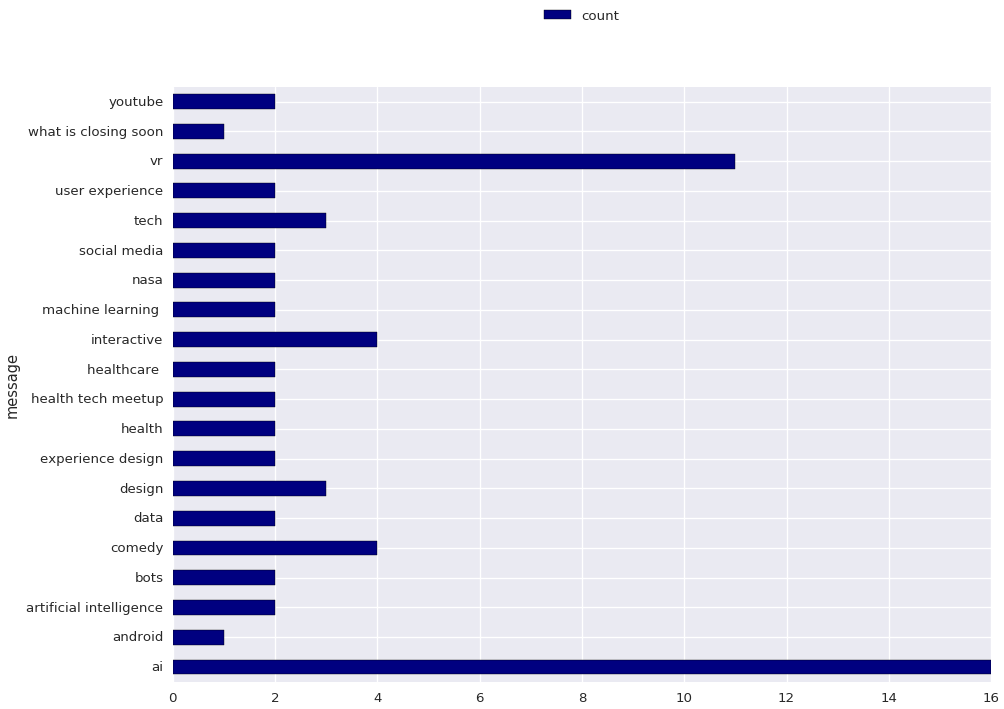

In [13]:
display(interactive_dialog_by_message_df.limit(20))

### Display PixieDust Pie Chart
Finally, we'll take the top 10 most popular search terms and display them in a pie chart using PixieDust:


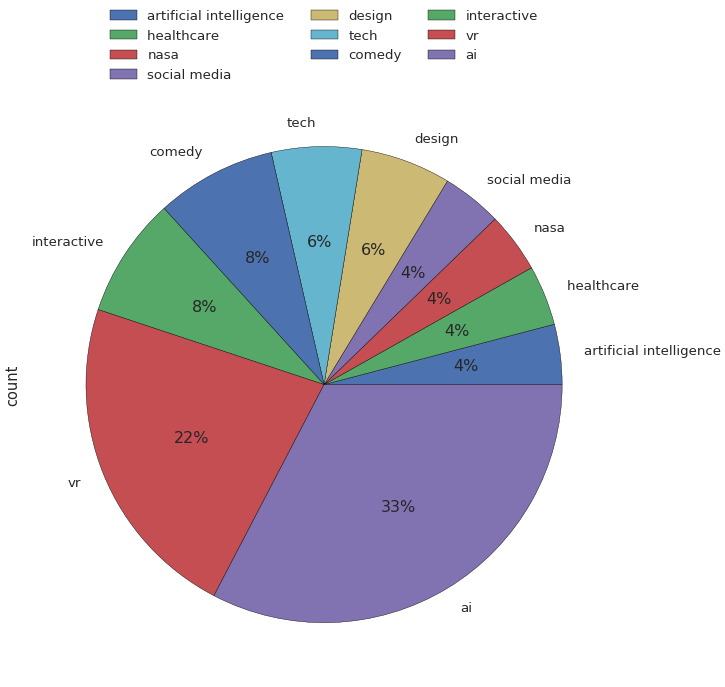

In [15]:
display(interactive_dialog_by_message_df.limit(10))